In [1]:
import os
import json
import time
import datetime as dt
import numpy as np
import pandas as pd
import factoroid as fr
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

WebSQL = fr.connector.MySQLDB('db-01')
DevSQL = fr.connector.MySQLDB('db-dev')

Successfully connected; Factorid web services
Successfully connected; Factoroid development


In [2]:
from model.utils_function import *
from model.utils_cycle import *
from model.utils_output import *
from model.utils_main import *
from model.utils_preprocessor import *

In [9]:
now = dt.datetime(2022, 4, 12, 8)
# now = dt.datetime.now().replace(hour=8, minute=0, second=0, microsecond=0)
# now = now - dt.timedelta(days=2) if now.weekday() == 0 else now
print(now)

2022-04-12 08:00:00


In [10]:
str_datetime = str(now.date())
if not os.path.exists(f'./result/{str_datetime}'):
    os.mkdir(f'./result/{str_datetime}')

In [11]:
# SO data load
# SO data merge

so = pd.DataFrame(WebSQL.query(f'''
                                    SELECT stop.equipment_name AS equipment_name, stop.order_number AS so, stop.gop AS gop, stop.material AS material, stop.qty AS qty, start.report_date AS start_time, MAX(stop.report_date) AS stop_time
                                    FROM so_log_yulkok AS stop
                                    LEFT JOIN (SELECT equipment_name, order_number, gop, material, qty, MIN(report_date) AS report_date
                                            FROM so_log_yulkok
                                            WHERE equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                     'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                     'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                            AND status = '보고시작' AND report_date >= '{str(now - dt.timedelta(days=7))}' AND report_date <= '{str(now)}'
                                            GROUP BY equipment_name, order_number, gop, material, qty) AS start
                                            ON stop.equipment_name = start.equipment_name AND stop.order_number = start.order_number AND stop.gop = start.gop AND stop.material = start.material AND stop.qty = start.qty
                                    WHERE stop.equipment_name IN ('G3020 #1', 'CMI 3S #8', 'DMC60T#3', 'DMU 50 3rd Generation #2', 'ECOSPEED F1040 #2', 'EVER 7', 
                                                                  'FMS ZT-800 #3', 'H5-800', 'HFP1540 PROTO', 'HU80A-5X', 'KT MODU LINE #3', 'MC18200 #1',
                                                                  'MP2150', 'MYNX500#1', 'SB-416', 'SNK RB-200F(2060)', 'VC630/5AX #S4', 'VMP8-6P', 'YK 3070(TCP-30TS)')
                                    AND stop.status = '보고완료' AND stop.completion_flag = 'X' AND stop.report_date >= '{str(now - dt.timedelta(days=1))}' AND stop.report_date < '{str(now)}'
                                    GROUP BY equipment_name, so, gop, material, qty;
                                '''), columns=['equipment_name', 'so', 'gop', 'material', 'qty', 'start_time', 'stop_time', 'total_runtime'])

so.total_runtime = round((so.stop_time - so.start_time) / np.timedelta64(1,'h'), 3)
so = so.dropna().sort_values(by=['equipment_name', 'start_time']).reset_index(drop=True)

In [12]:
cycle_summary = pd.DataFrame(columns=['factory_id', 'process_id', 'equipment_id', 'equipment_name', 
                                      'material', 'so', 'gop', 'qty', 'cycle_number', 'start_time', 'stop_time',
                                      'spindle', 'idle_inter', 'total'])

In [13]:
so_g = so.groupby(['equipment_name'])
so_g_keys = list(so_g.groups.keys())
if not so_g_keys:
    print('Not found SO data')
else:
    print(f'\nSO data length: {so.shape[0]}\n{", ".join(so_g_keys)}\n')

for machine in so_g_keys:
    so_df_ = so_g.get_group(machine).reset_index(drop=True)
    so_df_ = so_df_[so_df_.total_runtime > 0.1]
    print(f'{machine}: {so_df_.shape[0]}')


SO data length: 44
DMC60T#3, DMU 50 3rd Generation #2, ECOSPEED F1040 #2, EVER 7, H5-800, HFP1540 PROTO, MYNX500#1, SB-416, SNK RB-200F(2060)

DMC60T#3: 2
DMU 50 3rd Generation #2: 1
ECOSPEED F1040 #2: 5
EVER 7: 2
H5-800: 2
HFP1540 PROTO: 2
MYNX500#1: 7
SB-416: 19
SNK RB-200F(2060): 1


In [15]:
machine = 'ECOSPEED F1040 #2'
so_df_ = so_g.get_group(machine).reset_index(drop=True)
so_df_ = so_df_[so_df_.total_runtime > 0.1]
stop_times = list(so_df_.stop_time.values)
print(machine)
print(f'DataFrame Length: {so_df_.shape[0]}')
so_df_

ECOSPEED F1040 #2
DataFrame Length: 5


equipment_name          so gop        material qty          start_time  \
0  ECOSPEED F1040 #2  D200600510  10  V5725352120800   1 2022-04-11 08:54:52   
1  ECOSPEED F1040 #2  D200593300  30  V5725352020400   1 2022-04-11 09:57:51   
2  ECOSPEED F1040 #2  D200600290  20  V5725352020400   1 2022-04-11 13:34:25   
3  ECOSPEED F1040 #2  D200600300  20  V5725352020400   1 2022-04-11 15:11:52   
4  ECOSPEED F1040 #2  D200600290  30  V5725352020400   1 2022-04-11 16:35:40   

            stop_time  total_runtime  
0 2022-04-11 09:57:40          1.047  
1 2022-04-11 13:34:16          3.607  
2 2022-04-11 14:48:48          1.240  
3 2022-04-11 16:35:29          1.394  
4 2022-04-11 19:37:21          3.028


    index: 1,	D200593300	30	V5725352020400	1      2022-04-11 09:57:51 ~ 2022-04-11 13:34:16
    


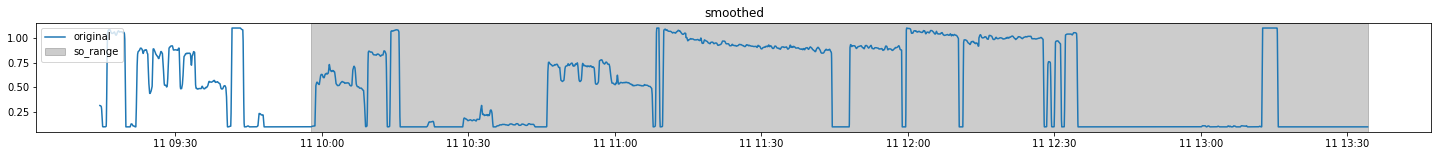

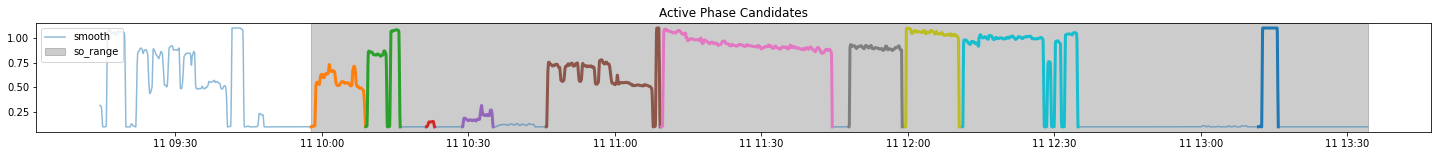

##########################################################################################
Current best candidates plot


##########################################################################################
Current best candidates:  -11,-1:0,9
Size of active phases:  10
##########################################################################################


_______________________________________________________________________________________
1. 'Y': Select best candidates or Press enter with empty blank
2. 'N': best candidates looks good...


[13] [(-11, -1), (0, 9)]


In [16]:
# index_, plotting, company = 0, True, 'yg'
plotting, company = True, 'yg'
config.plot = plotting
config.company = company

for idx_, so_ in so_df_[1:2].iterrows():
    
    ######################
    ### read parameter ###
    ######################

    order_number_, gop_, material_, quantity_, so_time_ = so_.so, so_.gop, so_.material, int(so_.qty), so_.total_runtime
    parameter, gap, threshold, min_threshold, smooth_factor, step, upper_limit, mac_main, window, max_cycle, idle_value = params(machine)
    
    print(f'''
    {'='*100}
    index: {idx_},\t{order_number_}\t{gop_}\t{material_}\t{quantity_}      {so_.start_time} ~ {so_.stop_time}
    {'='*100}
    ''')

    # exchange padded time
    so_range = [so_.start_time, so_.stop_time]
    padded_time = so_time_*0.2 if ((so_time_ / quantity_) >= 1) or (quantity_ > 1) else so_time_*0.5

    ########################
    ### define timeRange ###
    ########################

    timeWindowRedefine = False
    while True:
        patterns, candidates, pattern_index, start_time, _, lll, _ = pattern_history_parse(machine, order_number_)
        # print(patterns)
        if timeWindowRedefine == False: pass
        else:
            print(f"Current time window of interest: {str(so_range[0])} ~ {str(so_range[1])}")
            time.sleep(1)
            start_ = input("Proposed new SO start datetime (format: YYYY-MM-DD HH:MM:SS): ")
            stop_ = input("Proposed new SO stop datetime (format: YYYY-MM-DD HH:MM:SS): ")
            so_range = [pd.to_datetime(start_), pd.to_datetime(stop_)]
            
        padded_range = [so_range[0] - dt.timedelta(hours=padded_time), so_range[1] + dt.timedelta(hours=padded_time)]
        plot_start_time = str(padded_range[0])
        plot_stop_time = str(stop_times[idx_+1]).replace("T", " ")[:19] if stop_times[idx_+1:idx_+2] and so_.stop_time not in stop_times[idx_+1:] else str(padded_range[1])
        period_ = fr.utils.Period([plot_start_time, plot_stop_time])

        row = WebSQL.get_data(mac=mac_main, period=period_.utc)
        data_ = fr.processor.preprocess(row)
        # data_ = signal_preprocessing(data_)
        next_data, current_data = data_[data_.timestamp > so_range[1]], data_[data_.timestamp <= so_range[1]]

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=next_data.timestamp, y=next_data.value, mode='lines', line=dict(width=2, color='#1f77b4'), opacity=0.4, name='next SO', showlegend=True))
        fig.add_trace(go.Scatter(x=current_data.timestamp, y=current_data.value, mode='lines', line=dict(width=3, color='#1f77b4'), opacity=1.0, name='current data', showlegend=True))
        fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
        fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=200, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation='h', yanchor='bottom', y=1.04, xanchor='left', x=0))
        fig.show()
        time.sleep(2)

        proceed = input("Do we need to change time window to detect at least one complete cycle? (Y/N): ")
        if proceed == "N":
            break
        timeWindowRedefine = True

    # temp dataRange, [padded_range[0], so_range[1]]
    temp = data_[(data_.timestamp > plot_start_time) & (data_.timestamp <= so_range[1])]
    
    # cleaning + smoothing + inactive phase detection
    times_, y_ = cleaning(temp, smooth_factor, min_threshold)
    smooth_ = smoothing(y_, step)
    times, ss, inactive_cycles_ = inactive_phase_cleaning_normalization(smooth_, times_, upper_limit, window, so_range)

    # active phase detection
    cycles_ = active_phase(ss, times, threshold, upper_limit, max_cycle * 60, gap, idle_value)
    cycles = cycle_generate(cycles_, times, ss, inactive_cycles_, so_range)

    ###############################
    ### define machineParameter ###
    ###############################

    parameterRedefine = False
    while True:
        if parameterRedefine == False: pass
        else:
            times, ss, cycles = params_redefine(temp, machine, so_range)
            parameter, gap, threshold, min_threshold, smooth_factor, step, upper_limit, mac_main, window, max_cycle, idle_value = params(machine)
            print('Parameter Redefine')
        
        active_phase_idx = 0
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=pd.to_datetime(times), y=ss, mode='lines', opacity=0.3, name='smooth', showlegend=False))
        for _, c in enumerate(cycles):
            xx, yy = pd.to_datetime([aa[0] for aa in c]), [aa[1] for aa in c]
            center_idx, max_yy = int(len(xx)//2), max(yy)
            fig.add_trace(go.Scatter(x=xx, y=yy, mode='lines', name=f'{active_phase_idx}', line=dict(width=3)))
            fig.add_trace(go.Scatter(x=[xx[center_idx]], y=[max_yy*1.1], mode='markers+text', text=f'{active_phase_idx}',
                            textposition='middle center', textfont=dict(family='bold', color='black'),
                            marker=dict(color='gray',opacity=0.2,size=15, line=dict(color='black', width=2)), showlegend=False))
            active_phase_idx += 1
        fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=True)
        fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
        fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2))
        fig.show()
        time.sleep(2)
        
        proceed = input("Do we need to change parameter to detect at least one complete cycle? (Y/N): ")
        if proceed == "N":
            break
        parameterRedefine = True

    # cycle parameter
    cycle_parameter = parameter[machine]['cycle']
    # cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 else 1000
    cycle_parameter['L'] = 500 if cycle_parameter['lower_limit'] <= 100 and machine not in ['SNK RB-200F(2060)'] else 1000
    cycle_parameter['min_dist'] = round(max(cycle_parameter['lower_limit'] ** 0.4, 2.8), 1) * 1.3
    cycle_parameter['order'] = int(min(max(cycle_parameter['lower_limit'] ** 0.6, 5), 15))
    cycle_parameter['gap'] = 50
    cycle_parameter['n'] = 5
    cycle_parameter['cycle_gap'] = [30, 60][machine not in {"G3020 #1"}]

    ###########################
    ### detect machineCycle ###
    ###########################
    
    # quantity_ 장비마다 스핀들 배수 적용
    quantity_ = quantityRedefine(machine, quantity_)

    # order_number 미사용
    patterns, candidates, first_phase, last_phase = pattern_detector(cycles, cycle_parameter, machine, order_number_)
    output, complete_cycle = best_cycle(patterns, quantity_)

    output, patterns, candidates, machine, complete_cycle, first_phase, last_phase, flag = so_pattern_output(output, patterns, candidates, machine, complete_cycle, times, ss, cycles, first_phase, last_phase,  material_, order_number_, cycle_parameter)
    
    # if the flag is True (pattern was found manually, let's revise the parameter file
    if flag and output != []:
        timeInterval = [patterns[i][0]//60 for i in output]
        if max(timeInterval) > cycle_parameter['upper_limit']:
            cycle_parameter['upper_limit'] = int(max(timeInterval) * 1.1)
        if min(timeInterval) < cycle_parameter['lower_limit']:
            cycle_parameter['lower_limit'] = int(min(timeInterval) * 0.9)
        parameter[machine]['cycle'] = cycle_parameter
        print("Updating the parameter with the latest information")
        with open('./parameter/equipment_properties.json', 'w') as fout:
            json.dump(parameter, fout)
    
    print(output, complete_cycle)
    # # only if we have valid cycle output; otherwise, this step is not necessary
    # if output != [] and complete_cycle != []:
        # store_cycle_output_and_plot(output, patterns, candidates, machine, complete_cycle, times, ss, cycles, first_phase, last_phase, material_, order_number_, store=True)

    # # cycle summary
    if complete_cycle != []:
        cycle_summary = so_cycle_output(complete_cycle, cycles, cycle_summary, machine, material_, order_number_, gop_)

In [17]:
cycles[0][-1][0]

numpy.datetime64('2022-04-11T10:08:58.890000000')

In [25]:
so_range

[Timestamp('2022-04-11 09:57:51'), Timestamp('2022-04-11 13:34:16')]

In [28]:
# times_, ss_ = df_.timestamp, df_.value

active_phase_idx = 0
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(times), y=ss, mode='lines', opacity=0.4, name='Signal', showlegend=True))
for idx, c in enumerate(cycles[0:11]):
    names = set()
    xx, yy = pd.to_datetime([aa[0] for aa in c]), [aa[1] for aa in c]
    center_idx, max_yy = int(len(xx)//2), max(yy)
    fig.add_trace(go.Scatter(x=xx, y=yy, mode='lines', name=f'operation', line=dict(width=3, color='blue'), showlegend=True))
    if idx < 9:
        start_, end_ = cycles[idx][-1][0], cycles[idx+1][0][0]
        inactive = [[t, ss[idx]] for idx,t in enumerate(times) if start_<=t<=end_]
        xx_, yy_ = [i_[0] for i_ in inactive], [i_[1] for i_ in inactive]
        fig.add_trace(go.Scatter(x=xx_, y=yy_, mode='lines', name=f'idle_inter', line=dict(width=3, color='red'), showlegend=True))
        fig.add_vrect(x0=str(start_), x1=str(end_), opacity=0.3, fillcolor='red', name='idle_inter')
    fig.for_each_trace(lambda trace: trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
fig.add_vrect(x0=str(so_range[0]), x1=str(so_range[1]), opacity=0.2, fillcolor='black')
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False, rangeslider_visible=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True, showgrid=False)
fig.update_layout(autosize=False, plot_bgcolor='white', width=1500, height=250, margin=dict(l=5,r=5,b=10,t=10,pad=2), legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0))
fig.show()

In [45]:
df_ = temp[(temp.timestamp >= '2022-04-08 07:30') & (temp.timestamp <= '2022-04-08 13:10')]

In [36]:
cycles[0:11]

[[[numpy.datetime64('2022-04-08T07:39:00.117000000'), 0.1, 6431],
  [numpy.datetime64('2022-04-08T07:39:02.117000000'), 0.1, 6432],
  [numpy.datetime64('2022-04-08T07:39:04.117000000'),
   0.19814582468691583,
   6433],
  [numpy.datetime64('2022-04-08T07:39:06.117000000'),
   0.29629164937383157,
   6434],
  [numpy.datetime64('2022-04-08T07:39:08.120000000'),
   0.39443747406074736,
   6435],
  [numpy.datetime64('2022-04-08T07:39:10.120000000'),
   0.49258329874766316,
   6436],
  [numpy.datetime64('2022-04-08T07:39:12.120000000'),
   0.5928258297605457,
   6437],
  [numpy.datetime64('2022-04-08T07:39:14.120000000'), 0.693068360773428, 6438],
  [numpy.datetime64('2022-04-08T07:39:16.120000000'),
   0.6951650670993946,
   6439],
  [numpy.datetime64('2022-04-08T07:39:18.120000000'),
   0.6972617734253616,
   6440],
  [numpy.datetime64('2022-04-08T07:39:20.120000000'),
   0.6993584797513283,
   6441],
  [numpy.datetime64('2022-04-08T07:39:21.803000000'),
   0.7014551860772948,
   6442],
 

In [35]:
cycles[0:11][-1][-1]

[numpy.datetime64('2022-04-08T12:55:34.816000000'), 0.1, 15928]

In [116]:
cycle_summary

factory_id process_id equipment_id equipment_name        material  \
0           24         50          102      CMI 3S #8      182A2408-5   
1           23         49          115       DMC60T#3      182A5605-4   
2           23         49          115       DMC60T#3      182A5605-4   
3           23         49          115       DMC60T#3      182A5605-4   
4           23         49          115       DMC60T#3      182A5605-4   
..         ...        ...          ...            ...             ...   
246         24         50          103         SB-416  D572-57837-203   
247         24         50          103         SB-416  D572-57837-203   
248         24         50          103         SB-416  D572-57837-203   
249         24         50          103         SB-416  D572-57837-203   
250         24         50          103         SB-416  D572-57849-203   

             so gop qty cycle_number                 start_time  \
0    D200595370  30   1            1 2022-04-13 11:45:45.702000   
1    D200594470  40  10            1 2022-04-13 04:46:56.507394   
2    D200594470  40  10            2 2022-04-13 06:17:02.944000   
3    D200594470  40  10            3 2022-04-13 07:12:34.975000   
4    D200594470  40  10            4 2022-04-13 08:44:23.153000   
..          ...  ..  ..          ...                        ...   
246  D200587590  20   1            1 2022-04-14 01:23:10.235104   
247  D200587510  20   1            1 2022-04-14 02:21:50.556484   
248  D200587470  20   1            1 2022-04-14 03:43:38.845557   
249  D200587400  20   1            1 2022-04-14 04:40:51.045783   
250  D200589070  20   1            1 2022-04-14 06:06:27.340873   

                     stop_time  spindle  idle_inter  total  
0   2022-04-13 19:06:03.314451    4.693       2.646  7.338  
1   2022-04-13 06:03:11.229548    0.610       0.661  1.271  
2   2022-04-13 06:53:01.153000    0.600       0.000  0.600  
3   2022-04-13 07:48:33.296000    0.600       0.000  0.600  
4   2022-04-13 09:20:19.205000    0.599       0.000  0.599  
..                         ...      ...         ...    ...  
246 2022-04-14 02:08:50.495762    0.650       0.111  0.761  
247 2022-04-14 03:07:16.715939    0.671       0.086  0.757  
248 2022-04-14 04:29:50.872000    0.626       0.144  0.770  
249 2022-04-14 05:51:29.195799    0.661       0.516  1.177  
250 2022-04-14 06:46:53.487371    0.489       0.185  0.674  

[251 rows x 14 columns]

In [120]:
cycle_summary.to_csv(f'./result/{now.strftime("%Y-%m-%d")}/CycleSummary.csv', index=False)

In [117]:
cycle_operation, cycle_records = db_insert(cycle_summary, 'yk_operating_cycle')
WebSQL.query_records(cycle_operation, cycle_records)
DevSQL.query_records(cycle_operation, cycle_records)

251

In [118]:
material_summary = group_by_summary(cycle_summary)
drop_qty = so.drop(['qty'], axis=1)
material_summary = material_summary.merge(drop_qty, how='left', on=['equipment_name', 'material', 'so', 'gop'])
material_summary.to_csv(f'./result/{now.strftime("%Y-%m-%d")}/MaterialSummary.csv', index=False)

In [119]:
material_operation, material_records = db_insert(material_summary, 'yk_operating_material')
WebSQL.query_records(material_operation, material_records)
DevSQL.query_records(material_operation, material_records)

78